# 1. Import

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np

import matplotlib
#matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

### Importing Data

In [2]:
df = pd.read_csv('/Users/nasim/Data_Science/Springboard/FraudDetection/PS_20174392719_1491204439457_log.csv')
#df = df[:5000]
df.describe()
# Drop duplicate rows:
df = df.drop_duplicates()

#### step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
#### type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
#### amount - amount of the transaction in local currency.
#### nameOrig - customer who started the transaction
#### oldbalanceOrg - initial balance before the transaction
#### newbalanceOrig - new balance after the transaction
#### nameDest - customer who is the recipient of the transaction
#### oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
#### newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
#### isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
#### isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction."""

#### Transaction types are defined based on the following reference: http://bth.diva-portal.org/smash/get/diva2:955852/FULLTEXT06.pdf
#### CASH-IN is the process of increasing the balance of account by paying in cash to a merchant.
#### CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account.
#### DEBIT is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account.
#### PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.
#### TRANSFER is the process of sending money to another user of the service through the mobile money platform.

### Some column names can be changed:

In [3]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest          object
oldBalanceDest    float64
newBalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB


In [5]:
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


### Are there any missing values?

In [6]:
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldBalanceOrig    False
newBalanceOrig    False
nameDest          False
oldBalanceDest    False
newBalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

# 2. Exploratory Data Analysis (EDA) 

Number of legitimate transactions: 6354407
Number of fraudulent transactions: 8213


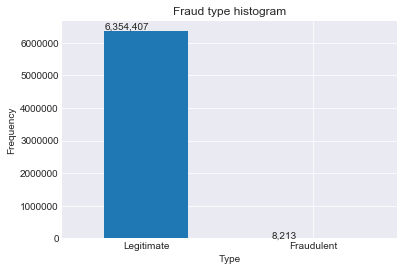

In [7]:
count_Fraud = df['isFraud'].map({0:'Legitimate', 1:'Fraudulent'}).value_counts()
print('Number of legitimate transactions:', count_Fraud[0])
print('Number of fraudulent transactions:', count_Fraud[1])
ax = count_Fraud.plot(kind = 'bar', rot=0)
plt.title("Fraud type histogram")
plt.xlabel("Type")
plt.ylabel("Frequency")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

### Checking types of fradulant and legitimate trasactions:

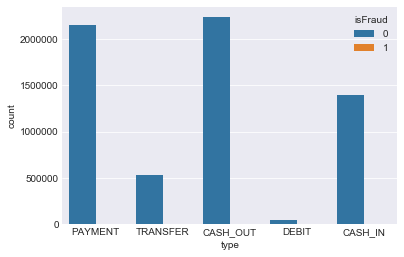

In [8]:
ax = sns.countplot(x='type', data=df, hue='isFraud')

#### The data is highly imbalanced!

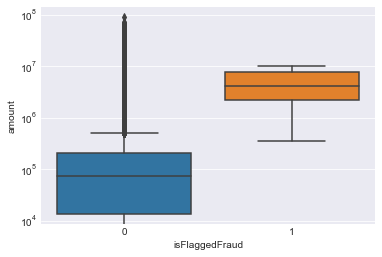

In [9]:
ax = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = df)
ax.set_yscale('log')

In [10]:
OldMinusNewBalance = df['oldBalanceOrig']-df['amount']==df['newBalanceOrig']
print(OldMinusNewBalance.value_counts())

False    5413997
True      948623
dtype: int64


#### amount is not always equal to the difference between old and new balance!!

### Check the types of tranactions:

In [11]:
print(df['type'].unique())

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


### Check types of tranactions which has fradulent activities:

In [12]:
print(df.loc[df['isFraud']==1]['type'].unique())

['TRANSFER' 'CASH_OUT']


### Check the number of fradulent activities by type of tranaction:

In [13]:
print('Number of TRANSFER fradulent activities:',df.loc[(df['isFraud']==1)&(df['type']=='TRANSFER')]['type'].count())
print('Number of CASH-OUT fradulent activities:',df.loc[(df['isFraud']==1)&(df['type']=='CASH_OUT')]['type'].count())

Number of TRANSFER fradulent activities: 4097
Number of CASH-OUT fradulent activities: 4116


### Print out the amount for fradulent activities:

In [14]:
df2 = df.loc[df['isFraud']==1][['type', 'amount']]
print(df2[:6])

         type   amount
2    TRANSFER    181.0
3    CASH_OUT    181.0
251  TRANSFER   2806.0
252  CASH_OUT   2806.0
680  TRANSFER  20128.0
681  CASH_OUT  20128.0


### Are all fradulent transfer activities proceeds by cash out?

In [15]:
print(df2.loc[df2.type=='TRANSFER']['amount'].count())
print(df2.loc[df2.type=='CASH_OUT']['amount'].count())

4097
4116


### Min and max amount of fradulent transactions:

In [16]:
# Min and max amount of fradulent transactions:
print('Minumum amount of fradulent TRANSFER:',df.loc[(df['isFraud']==1)&(df['type']=='TRANSFER')]['amount'].min())
print('Minumum amount of fradulent CASH OUT (other than 0):',df.loc[(df['isFraud']==1)&(df['type']=='CASH_OUT')&(df['amount']!=0)]['amount'].min())
print('Maximum amount of fradulent TRANSFER:',df.loc[(df['isFraud']==1)&(df['type']=='TRANSFER')]['amount'].max())
print('Maximum amount of fradulent CASH OUT:',df.loc[(df['isFraud']==1)&(df['type']=='CASH_OUT')&(df['amount']!=0)]['amount'].max())

Minumum amount of fradulent TRANSFER: 63.8
Minumum amount of fradulent CASH OUT (other than 0): 63.8
Maximum amount of fradulent TRANSFER: 10000000.0
Maximum amount of fradulent CASH OUT: 10000000.0


### Check if all the transactions which are "isFlaggedFraud" are the one with transaction amounts higher than 200,000, as described in the column definitios?

In [17]:
print('Number of isFlaggedFraud=1 cases where the amount if lower or equal to 200000:',df.loc[(df['isFlaggedFraud']==1)&(df['amount']<=200000)]['isFlaggedFraud'].count())

Number of isFlaggedFraud=1 cases where the amount if lower or equal to 200000: 0


### What are the type of isFlaggedFraud transaction?

In [18]:
print('Type of transactions in which isFlaggedFraud=1:',df.loc[df['isFlaggedFraud']==1]['type'].unique())

Type of transactions in which isFlaggedFraud=1: ['TRANSFER']


### Check if there is any TRANSFER over 200000, in which isFlaggedFraud is not set to 1?

In [19]:
print('Number of TRANSFERs over 200000 which are not flagged as isFlaggedFraud:',df.loc[(df['amount']> 200000)&(df['isFlaggedFraud']==0)&(df['type']=='TRANSFER')]['type'].count())

Number of TRANSFERs over 200000 which are not flagged as isFlaggedFraud: 409094


#### So it seems that any TRANSFER over 200000 is not necessarily flagged as isFlaggedFraud=1, which is in contrast with the definition.

### Is there any correlation between isFlaggedFraud and isFlaggedFraud?

In [20]:
print('Number of cases where isFlaggedFraud=1 but isFraud=0:',df.loc[(df['isFlaggedFraud']==1)&(df['isFraud']==0)]['type'].count())

Number of cases where isFlaggedFraud=1 but isFraud=0: 0


#### So whenever isFlaggedFraud=1, there is actually a fraud case: isFraud = 1

In [21]:
print('Number of cases where isFraud=1 but isFlaggedFraud=0:',df.loc[(df['isFraud']==1)&(df['isFlaggedFraud']==0)]['type'].count())

Number of cases where isFraud=1 but isFlaggedFraud=0: 8197


#### So there are 8197 cases which are actually Fraud cases but isFlaggedFraud has failed to flag them as fradulent.

### Make a dataframe for FlaggedFraud TRANSFERs:

In [22]:
df_transfer_flagged = df.loc[(df['type']=='TRANSFER')&(df['isFlaggedFraud']==1)]
print('Number of TRANSFERs where flagged as fraud:', df_transfer_flagged['isFlaggedFraud'].count())

Number of TRANSFERs where flagged as fraud: 16


### Check for isFlaggedFraud and TRANSFER, what are the values and difference of oldBalanceDest and newBalanceDest

In [23]:
df_transfer_flagged['new-oldBalanceDest']=df_transfer_flagged['newBalanceDest']-df_transfer_flagged['oldBalanceDest']
print('Sum of difference between new and old balance of destinations for flagged transfers:',df_transfer_flagged['new-oldBalanceDest'].sum())
print('Number of non-zero old balance of destinations for flagged transfers:', df_transfer_flagged.loc[df_transfer_flagged['oldBalanceDest']!=0]['oldBalanceDest'].count())

Sum of difference between new and old balance of destinations for flagged transfers: 0.0
Number of non-zero old balance of destinations for flagged transfers: 0


#### So any TRANSFER that has been flagged fradulent, does not have any old or new destination balances. This can be due to suspension of the transfers because of the fraud flag. So destination balances do not give us any condition for flagging a transaction fraud. 

### Are isFlaggedFraud TRANSFERs for more than one transaction by a customer?

In [24]:
df3 = df_transfer_flagged.groupby("nameOrig").count()
print('Number of times where a customer with isFlaggedFraud TRANSFER had more than one tranaction:', (df3['type']>1).sum())

Number of times where a customer with isFlaggedFraud TRANSFER had more than one tranaction: 0


#### Since the above number is zero, No customer with FlaggedFraud TRANSFER had more than one transaction.

### Is there any case in FlaggedFraud TRANSFERs that the orig and destination name of a customer is the same?

In [25]:
print('Number of times where the origin and destination of a FlaggedFraud TRANSFER is the same person:', df_transfer_flagged.loc[df_transfer_flagged['nameOrig']==df_transfer_flagged['nameDest']]['nameOrig'].count())

Number of times where the origin and destination of a FlaggedFraud TRANSFER is the same person: 0


In [26]:
print('\nHave destinations for transactions flagged as fraud initiated other transactions?', (df_transfer_flagged.nameDest.isin(df.nameOrig)).any()) # False


Have destinations for transactions flagged as fraud initiated other transactions? False


#### It seems that isFlaggedFraud does not play any significant meaningful role is setting Fraud cases. Even though isFraud is set whenever isFlaggedFraud is set to true, isFlaggedFraud is on only for 16 TRANSFERs and we could not find a logical relation for this being on and the othe part of data. So isFlaggedFraud column will be removed in this dataset. 

### Is there any record of Fraud for names starting with M (Merchants)?

In [27]:
df_M = df.loc[(df.nameOrig.str.startswith('M')) | (df.nameDest.str.startswith('M'))]
df_M.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


In [28]:
print('Number of fraudulent cases involving merchants:',df_M.loc[df_M.isFraud==1]['isFraud'].count())

Number of fraudulent cases involving merchants: 0


#### There is no record of balance from clients that start with M (Merchants). 
#### According to the definitions mentioned above, a merchant should be involved in both CASH-IN and CASH-OUT transactions. 
#### Since there are many CASH-OUT cases in fradulent transactions, and we don't see any merchant involved in them, it can be concluded that the name columns are not defined properly and can be dropped.

# 3. Data Wrangling

In [29]:
Y = df['isFraud']

#### Since there are only two types of transactions involved in fraud, we will delete the other rows:

In [30]:
X = df.loc[(df['type']=='TRANSFER') | (df['type']=='CASH_OUT')]
X = X.drop(['isFlaggedFraud','isFraud', 'nameOrig', 'nameDest'], axis = 1)
X_Fraud = X.loc[Y==1]
X_NonFraud = X.loc[Y==0]
X.head(10)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,TRANSFER,181.00,181.00,0.0,0.0,0.00
3,1,CASH_OUT,181.00,181.00,0.0,21182.0,0.00
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.0,51513.44
19,1,TRANSFER,215310.30,705.00,0.0,22425.0,0.00
24,1,TRANSFER,311685.89,10835.00,0.0,6267.0,2719172.89
42,1,CASH_OUT,110414.71,26845.41,0.0,288800.0,2415.16
47,1,CASH_OUT,56953.90,1942.02,0.0,70253.0,64106.18
48,1,CASH_OUT,5346.89,0.00,0.0,652637.0,6453430.91
51,1,CASH_OUT,23261.30,20411.53,0.0,25742.0,0.00
58,1,TRANSFER,62610.80,79114.00,16503.2,517.0,8383.29


#### There are lots of zero values in new and old destination balances even though the amount is not zero. These values may need to be replaced.

#### First we will look at the percentage of above condition for both fradulant and legitimate transactions:

In [31]:
print('Percentage of fradulant transactions where new and old original balances are zero, even though the amount is not zero:', X_Fraud.loc[(X_Fraud.amount!=0) & (X_Fraud.oldBalanceOrig==0) & (X_Fraud.newBalanceOrig==0)]['type'].count()/X_Fraud.type.count()*100,'%')
print('Percentage of legitimate transactions where new and old original balances are zero, even though the amount is not zero:', X_NonFraud.loc[(X_NonFraud.amount!=0) & (X_NonFraud.oldBalanceOrig==0) & (X_NonFraud.newBalanceOrig==0)]['type'].count()/X_NonFraud.type.count()*100,'%')

Percentage of fradulant transactions where new and old original balances are zero, even though the amount is not zero: 0.304395470595 %
Percentage of legitimate transactions where new and old original balances are zero, even though the amount is not zero: 47.373213197 %


#### It is clear that the old and new original balances being zero when amout is not zero happens much more often for fradulant trasactions. So it can be an indicator of the fraud. Therefore thses values should not be replaced.

#### We can do the same analysis as above for transactions where the new and old destination balances are zero. even though the amount is not zero:

In [32]:
print('Percentage of fradulant transactions where new and old destination balances are zero, even though the amount is not zero:', X_Fraud.loc[(X_Fraud.amount!=0) & (X_Fraud.oldBalanceDest==0) & (X_Fraud.newBalanceDest==0)]['type'].count()/X_Fraud.type.count()*100,'%')
print('Percentage of legitimate transactions where new and old dectination balances are zero, even though the amount is not zero:', X_NonFraud.loc[(X_NonFraud.amount!=0) & (X_NonFraud.oldBalanceDest==0) & (X_NonFraud.newBalanceDest==0)]['type'].count()/X_NonFraud.type.count()*100,'%')

Percentage of fradulant transactions where new and old destination balances are zero, even though the amount is not zero: 49.5555826129 %
Percentage of legitimate transactions where new and old dectination balances are zero, even though the amount is not zero: 0.0617624527731 %


#### In the above case the fradulant tranactions have much more zero destination balances. Therefore we do not replace these zero values. 

#### Instead we will create two new features calculating the error for both original and destination balances:

In [33]:
X_Fraud['errorBalanceOrig']= X_Fraud['newBalanceOrig']+X_Fraud['amount']-X_Fraud['oldBalanceOrig']
X_NonFraud['errorBalanceOrig']= X_NonFraud['newBalanceOrig']+X_NonFraud['amount']-X_NonFraud['oldBalanceOrig']
X_Fraud['errorBalanceDest']= X_Fraud['newBalanceDest']+X_Fraud['amount']-X_Fraud['oldBalanceDest']
X_NonFraud['errorBalanceDest']= X_NonFraud['newBalanceDest']+X_NonFraud['amount']-X_NonFraud['oldBalanceDest']

### Time Variations:

#### Next we will plot changes in fradulent and legitimate transactions over time. 

In [34]:
X_Fraud_t = X_Fraud.groupby(['step', 'type']).count().reset_index()
X_NonFraud_t = X_NonFraud.groupby(['step', 'type']).count().reset_index()
X_Fraud_t.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
0,1,CASH_OUT,9,9,9,9,9,9,9
1,1,TRANSFER,7,7,7,7,7,7,7
2,2,CASH_OUT,4,4,4,4,4,4,4
3,2,TRANSFER,4,4,4,4,4,4,4
4,3,CASH_OUT,2,2,2,2,2,2,2


In [35]:
X_NonFraud_t.index.names

FrozenList([None])

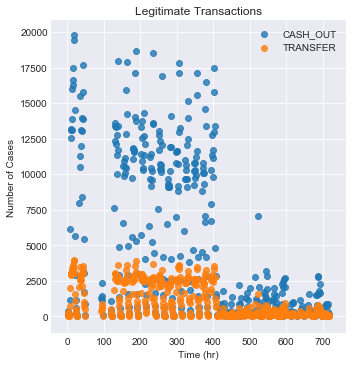

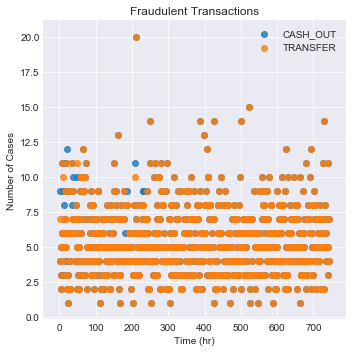

In [36]:
# Set up the matplotlib figure
#fig, ax = plt.subplots(ncols=2, sharey=True)

sns.lmplot(y='amount', x="step", data=X_NonFraud_t, fit_reg=False, hue='type', legend=False)
plt.legend(loc='upper right')
plt.title('Legitimate Transactions')
plt.xlabel('Time (hr)')
plt.ylabel('Number of Cases')

sns.lmplot(y='amount', x="step", data=X_Fraud_t, fit_reg=False, hue='type', legend=False)
plt.legend(loc='upper right')
plt.title('Fraudulent Transactions')
plt.xlabel('Time (hr)')
plt.ylabel('Number of Cases')

plt.tight_layout()
plt.show()

#### From the above figures, it is clear that for legitimate transactions, number of CASH-OUT is higher than TRANSFERs per hour, while for fradulent transacyions, CASH-OUT and TRANSFER are equal on many hours.

#### Also fradulent cases are more distributed over time than legitimate transactions. 